In [1]:
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
import pandas as pd

c:\Users\akbor hossain\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading dataset


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
len(df_test) ,len(df_train)

(450, 1840)

## Shuffle

In [3]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head(10)

,Text,Religious#Icon,Religious#Practice,Religious#Place,God,Religious#Community
0,বাংলাদেশ একটি মুসলিম দেশ,2,2,1,2,1
1,ধর্মনিরপেক্ষতার লেবাস লাগিয়ে ভারত ৬ ই ডিসেম্বর...,2,2,3,2,2
2,যদি স্কুল আমাকে শেখায় যে গণিত ঈশ্বরের সাথে সম...,2,2,2,1,2
3,শালা তুই কট্টরপন্থী হিন্দু,2,2,2,2,3
4,মুহাম্মদ চুদাইলে তুমার কি তুমাকে ত চুদাই নাই ত...,2,2,2,2,3
5,"জাজা কাল্লাহো খায়রান ড. জাকির নায়েক, আল্লাহ ...",1,2,2,1,2
6,রাবন সিতাকে নিয়ে গিয়ে চুদে মুদে শেষ করে যখন সি...,3,2,2,2,3
7,মসজিতে গিয়া ডগি স্টাইলে শুয়ে ১টার পিচে আরকটা প...,3,2,3,2,3
8,হয়ত মন্ত্রি মহুদয় এই সব কারনেই মালাউনের বাচ্চা...,2,2,2,2,3
9,যে জাতি মাকে ছেলে ছোদে বোনকে দাদা ছোদে আর তোদে...,2,2,2,2,3


In [4]:
import matplotlib.pyplot as plt
columns_to_plot = ['Religious#Icon',
'Religious#Practice','Religious#Place','God','Religious#Community']
#columns_to_plot = ['QUALITY','PERFOMANCE','CUSTOMER#SERVICE','COST','RECOMMENDATIONS']
frequency_counts = {column: df_train[column].value_counts() for column in columns_to_plot}

for column in  columns_to_plot:
    print(frequency_counts[column])
 

Religious#Icon
2    1650
3     121
1      69
Name: count, dtype: int64
Religious#Practice
2    1569
1     163
3     108
Name: count, dtype: int64
Religious#Place
2    1590
1     210
3      40
Name: count, dtype: int64
God
2    1425
1     344
3      71
Name: count, dtype: int64
Religious#Community
3    724
2    584
1    532
Name: count, dtype: int64


In [5]:
frequency_counts = {column: df_test[column].value_counts() for column in columns_to_plot}
for column in  columns_to_plot:
    print(frequency_counts[column])

Religious#Icon
2    432
3     10
1      8
Name: count, dtype: int64
Religious#Practice
2    411
3     25
1     14
Name: count, dtype: int64
Religious#Place
2    435
1     10
3      5
Name: count, dtype: int64
God
2    433
1     10
3      7
Name: count, dtype: int64
Religious#Community
3    221
2    214
1     15
Name: count, dtype: int64


In [6]:
import numpy as np

def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            sentiment = df.iloc[row, col]
            #if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            if sentiment == 1: one_hot = [1,0, 0] # Positive
            elif sentiment == 2: one_hot = [ 0, 1, 0] # Neutral
            elif sentiment == 3: one_hot = [0, 0, 1] # Negative
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return torch.tensor(outputs, dtype=torch.float32)


y_train = make_outputs(df_train)
y_test = make_outputs(df_test)

print('Train outputs:', y_train.shape)
print('Test outputs:', y_test.shape)


Train outputs: torch.Size([1840, 5, 3])
Test outputs: torch.Size([450, 5, 3])


# Preprocess

In [7]:
import re
def remove_punctuations(a):
    #punctuations = string.punctuation
    #punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    punctuations = '''``|¢|+-*/=৳–•।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰�￰৷￰'''
    for ch in punctuations:
      a = a.replace(ch, ' ')
    return a

def remove_foreign_word(a):
  a = "".join(i for i in a if i in ["।"] or 2432 <= ord(i) <= 2559 or ord(i)== 32)
  a=" ".join(a.split())
  return a


def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern= re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)
    return text


def digit_removal(text):
    digits = '0123456789'#'০১২৩৪৫৬৭৮৯'
    sample = text
    for ch in text:
      if ch in digits:
        text = text.replace(ch,' ')

    words = text.split()
    text = ' '.join(words)
    return text


In [8]:
df_train['Text'] = df_train.Text.apply(lambda x: remove_punctuations(remove_foreign_word(digit_removal(str(x)))))
df_test['Text'] = df_test.Text.apply(lambda x: remove_punctuations(remove_foreign_word(digit_removal(str(x)))))

df_train.tail(5)


,Text,Religious#Icon,Religious#Practice,Religious#Place,God,Religious#Community
1835,আল্লাহ তুমি সব মুসলিম নেতাদের ঐক্যবদ্ধ করে দাও...,2,2,2,1,1
1836,আর ভারতের মালাউনরা বাংলাদেশে হিন্দুদের কিছু হল...,2,2,2,2,3
1837,আরব দেশগুলো ন্যাটোর চেয়ে আরো শক্তিশালী সামরিক ...,2,2,1,2,2
1838,এটা করা প্রতিটি মুসলিম দেশ এর ঈমানী দায়িত্ব,2,2,1,2,1
1839,প্রতিটি ধর্ম প্রতিটি ধর্মীয় গোষ্ঠীর জন্য একটি...,2,1,2,2,2


# Finding maximum token lengths

In [9]:
df = df_train
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))
max_word_count = df['word_count'].max()
print(f"The maximum token length is: {max_word_count}")

The maximum token length is: 90


# Parameter settings

In [10]:
max_seq_length = 100 #256
batch = 10 # try 16,32
epochs = 2 # 5, 7
learning_rate=5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss().to(device)
print('model loaded to device..',device)


model loaded to device.. cuda


# Create Data loader

In [15]:
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
# Define your dataset
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.reshape(len(labels), -1)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]#.clone().detach()
        return text, label


In [13]:
train_texts = df_train['Text'].values.tolist()
test_texts = df_test['Text'].values.tolist()

# Creating dataloader
train_loader = DataLoader(CustomDataset(train_texts,y_train),batch_size=batch, shuffle=True,drop_last=True)
test_loader = DataLoader(CustomDataset(test_texts,y_test),batch_size=10,drop_last=False)
len(next(iter(train_loader))[0])

10

In [20]:
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

['বাংলাদেশ', 'একটি', 'মুসলিম', 'দেশ']

In [21]:
out = tokenizer(train_texts[0],padding= 'max_length',truncation=True, return_tensors='pt',max_length=10)
tokenizer.tokenize(train_texts[1838])

['এটা', 'করা', 'প্রতিটি', 'মুসলিম', 'দেশ', 'এর', 'ঈমান', '##ী', '[UNK]']

# Create model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel,AutoTokenizer

class ABSA(nn.Module):
    def __init__(self,model_name):
        super(ABSA, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name, output_hidden_states=True)
        self.dropout = nn.Dropout(0.2)
        self.classifiers = nn.ModuleList([nn.Linear(self.bert.config.hidden_size*4, 3) for _ in range(5) ])

    def forward(self,texts):
      features =self.tokenizer(texts, padding= 'max_length',
                                  truncation=True, return_tensors='pt',max_length=128)
      # print(features.keys())
      inputs,attention = features['input_ids'].to(device),features['attention_mask'].to(device)

      hidden_states = self.bert(inputs,
                    attention_mask=attention
                         ).hidden_states

      pooled_output = torch.cat(tuple(hidden_states[-4:]), dim=-1)[:, 0, :]
      x = self.dropout(pooled_output)
      outputs = torch.cat([(classifier(x))
            for classifier in self.classifiers], dim=-1)
      return outputs


# Train model

In [15]:
import os
import csv
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import f1_score



def Predict(inputs):
    inputs = inputs.reshape(inputs.size(0), -1, 3)
    return torch.argmax(inputs, dim=-1)


def evaluate_model(train_loss,tarining_accuracy,steps,MODEL_NAME):
    val_loss = []
    accuracies = []
    batch_f1 = []
    correct = 0.0
    total_examples = 0
    accuracy = 0.0
    with torch.no_grad():
      for batch_idx, (texts,labels) in enumerate(val_loader):
        outputs = model(texts).to(device)
        labels = labels.to(device)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())
        labels = Predict(labels)
        outputs = Predict(outputs)

        # accuracy
        correct += (outputs == labels).sum().item()
        total_examples += labels.numel()
        accuracy = correct / total_examples

        ##  f1-score
        predictions_flat = outputs.flatten().to("cpu").numpy()
        labels_flat = labels.flatten().to("cpu").numpy()
        f1 = f1_score(labels_flat, predictions_flat, average='weighted')
        batch_f1.append(f1)

      csv_file = f'{MODEL_NAME}_analysis.csv'
      file_exists = os.path.isfile(csv_file)
      with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['Steps', f'{MODEL_NAME}_Train_Loss',  f'{MODEL_NAME}_Validation_Loss',
                             f'{MODEL_NAME}_Accuracy',f'{MODEL_NAME}_Traininig_Accuracy',  f'{MODEL_NAME}_F1_Score'])
        writer.writerow([steps, train_loss, np.mean(val_loss), accuracy,tarining_accuracy, np.mean(batch_f1)])




def train_ABSA(model, loader, epochs,MODEL_NAME):
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    model_state_dict = model.state_dict()
    optimizer_state_dict = optimizer.state_dict()
    steps,total_steps,best_accuracy =  len(loader)//5,0,0.0


    for epoch in range(epochs):
        losses = []
        val_loss = []
        correct = 0.0
        total_examples = 0
        model.train()
        loop = tqdm(enumerate(loader),total = len(loader),leave = False)

        for batch_idx, (texts,labels) in loop:
            predictions = model(texts).to(device)
            labels = labels.to(device)
            loss = criterion(predictions,labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            labels = Predict(labels)
            predictions = Predict(predictions)
            correct += (predictions == labels).sum().item()
            total_examples += labels.numel()
            accuracy = correct / total_examples

            if epoch > 0 and (batch_idx+1)%steps==0 and best_accuracy<accuracy:
              best_accuracy = accuracy
              model_state_dict = model.state_dict()
              optimizer_state_dict = optimizer.state_dict()


            if (batch_idx+1)%steps == 0 :
              total_steps += steps
              print('\n')
              print(f'\n{MODEL_NAME} model saved => at batch : {batch_idx+1}\n')
              model.eval()
              evaluate_model(np.mean(losses),accuracy,total_steps,MODEL_NAME)
              torch.cuda.empty_cache()
              model.train()

            loop.set_description(f"Epoch [{epoch}/{epochs}]")
            loop.set_postfix(loss=np.mean(losses), accuracy=accuracy)
    checkpoint = {
                    "model_state_dict": model_state_dict,
                    "optimizer_state_dict": optimizer_state_dict}


    #print(PRETRAINED_MODEL)
    # saving best model
    PATH = f'model/{MODEL_NAME}'
    os.makedirs(os.path.dirname(PATH), exist_ok=True)
    torch.save(checkpoint, PATH)

    #saving final model
    checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()}
    PATH = f'model/{MODEL_NAME}_final'
    os.makedirs(os.path.dirname(PATH), exist_ok=True)
    torch.save(checkpoint, PATH)




**Bangla-BERT**

In [ ]:
model_name = "csebuetnlp/banglabert"
model = ABSA(model_name)
model = model.to(device)
train_ABSA(model,train_loader,epochs,'bangla-bert')

**Distil-BERT**

In [ ]:
# model_name = "distilbert-base-multilingual-cased"
# model = ABSA(model_name)
# model = model.to(device)
# train_ABSA(model,train_loader,epochs,'distil-bert')

In [ ]:
model1 = 'bangla-bert'
model2 = 'distil-bert'

# Analysis

In [ ]:
import pandas as pd
import os
bangla = pd.read_csv(f"{model1}_analysis.csv")
distil = pd.read_csv(f"{model2}_analysis.csv")
distil,bangla

(    Steps  distil-bert_Train_Loss  distil-bert_Validation_Loss  \
 0      25                0.383021                     0.320813   
 1      50                0.348799                     0.330519   
 2      75                0.334250                     0.375711   
 3     100                0.323991                     0.337495   
 4     125                0.313178                     0.395550   
 ..    ...                     ...                          ...   
 85   2150                0.031599                     0.453883   
 86   2175                0.031141                     0.471316   
 87   2200                0.033450                     0.439355   
 88   2225                0.033508                     0.430940   
 89   2250                0.033007                     0.428346   
 
     distil-bert_Accuracy  distil-bert_F1_Score  
 0                   0.82              0.773810  
 1                   0.77              0.670268  
 2                   0.74              0.709

In [ ]:
diba = distil.merge(bangla, how="inner", on="Steps")
diba

,Steps,distil-bert_Train_Loss,distil-bert_Validation_Loss,distil-bert_Accuracy,distil-bert_F1_Score,bangla-bert_Train_Loss,bangla-bert_Validation_Loss,bangla-bert_Accuracy,bangla-bert_F1_Score
0,25,0.383021,0.320813,0.82,0.773810,0.480029,0.337713,0.77,0.670268
1,50,0.348799,0.330519,0.77,0.670268,0.401487,0.298963,0.85,0.789923
2,75,0.334250,0.375711,0.74,0.709923,0.354436,0.318863,0.84,0.812447
3,100,0.323991,0.337495,0.76,0.742635,0.330052,0.282504,0.83,0.826507
4,125,0.313178,0.395550,0.76,0.751207,0.310427,0.263324,0.85,0.826513
...,...,...,...,...,...,...,...,...,...
85,2150,0.031599,0.453883,0.84,0.814646,0.027019,0.372864,0.89,0.890487
86,2175,0.031141,0.471316,0.86,0.847988,0.029397,0.357140,0.89,0.888358
87,2200,0.033450,0.439355,0.88,0.868960,0.029325,0.355843,0.89,0.888358
88,2225,0.033508,0.430940,0.86,0.847093,0.029270,0.346787,0.91,0.907796


### Validation  Accuracy

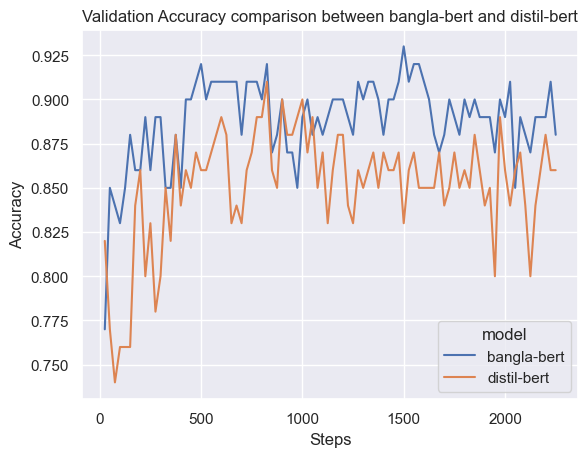

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

accData = {
    "steps": [],
    "accuracy": [],
    "model": []
}

for i,x in diba.iterrows():
    accData["steps"].append(x["Steps"])
    accData["steps"].append(x["Steps"])
    accData["accuracy"].append(x[f"{model1}_Accuracy"])
    accData["accuracy"].append(x[f"{model2}_Accuracy"])
    accData["model"].append(model1)
    accData["model"].append(model2)

accTable = pd.DataFrame(accData)
sns.set_theme()
sns.lineplot(data=accTable, x="steps", y="accuracy", hue="model")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title(f"Validation Accuracy comparison between {model1} and {model2}")
path = 'Accuracy_graph.png'
os.makedirs(os.path.dirname('eval/'), exist_ok=True)
plt.savefig(f'eval/{path}', bbox_inches='tight')

### Training accuracy


In [ ]:
# accData = {
#     "steps": [],
#     "accuracy": [],
#     "model": []
# }

# for i,x in diba.iterrows():
#     accData["steps"].append(x["Steps"])
#     accData["steps"].append(x["Steps"])
#     accData["accuracy"].append(x[f'{model1}_Traininig_Accuracy'])
#     accData["accuracy"].append(x[f'{model2}_Traininig_Accuracy'])
#     accData["model"].append(model1)
#     accData["model"].append(model2)

# accTable = pd.DataFrame(accData)
# sns.set_theme()
# sns.lineplot(data=accTable, x="steps", y="accuracy", hue="model")
# plt.xlabel("Steps")
# plt.ylabel("Accuracy")
# plt.title(f"Training Accuracy comparison between {model1} and {model2}")
# path = 'Training_Accuracy_graph.png'
# os.makedirs(os.path.dirname('eval/'), exist_ok=True)
# plt.savefig(f'eval/{path}', bbox_inches='tight')

## F1-Score

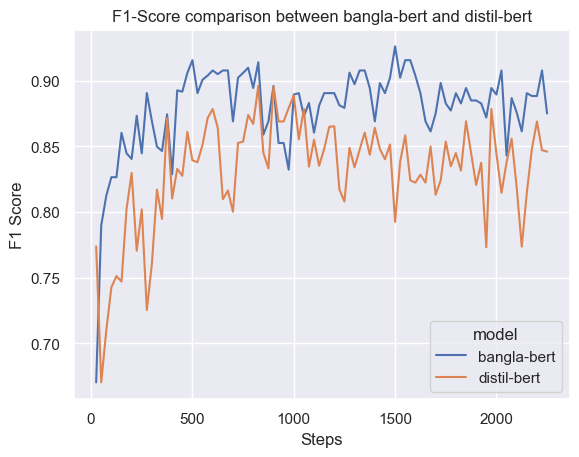

In [ ]:
accData = {
    "steps": [],
    "f1": [],
    "model": []
}

for i,x in diba.iterrows():
    accData["steps"].append(x["Steps"])
    accData["steps"].append(x["Steps"])
    accData["f1"].append(x[f"{model1}_F1_Score"])
    accData["f1"].append(x[f"{model2}_F1_Score"])
    accData["model"].append(model1)
    accData["model"].append(model2)

accTable = pd.DataFrame(accData)
sns.set_theme()
sns.lineplot(data=accTable, x="steps", y="f1", hue="model")
plt.xlabel("Steps")
plt.ylabel("F1 Score")
plt.title(f"F1-Score comparison between {model1} and {model2}")
path = 'F1_Score_graph.png'
os.makedirs(os.path.dirname('eval/'), exist_ok=True)
plt.savefig(f'eval/{path}', bbox_inches='tight')


## Loss function

**Distil-Bert Loss**

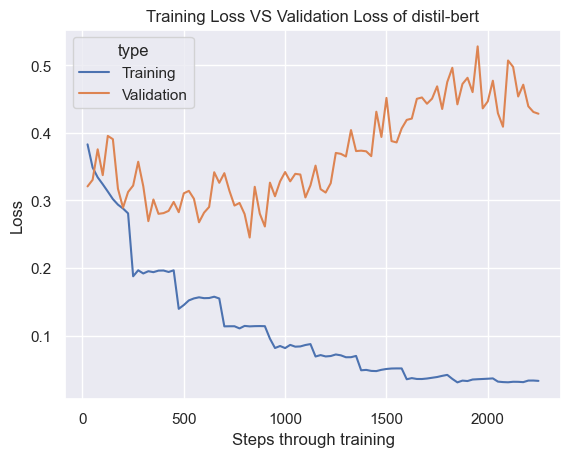

In [ ]:
lossData = {
    "steps": [],
    "loss": [],
    "type": []
}

for i,x in diba.iterrows():
    lossData["steps"].append(x["Steps"])
    lossData["steps"].append(x["Steps"])
    lossData["loss"].append(x[f"{model2}_Train_Loss"])
    lossData["loss"].append(x[f"{model2}_Validation_Loss"])
    lossData["type"].append("Training")
    lossData["type"].append("Validation")

lossTable = pd.DataFrame(lossData)
sns.set_theme()
sns.lineplot(data=lossTable, x="steps", y="loss", hue="type")
plt.xlabel("Steps through training")
plt.ylabel("Loss")
plt.title(f"Training Loss VS Validation Loss of {model2}")
path = f'Loss_{model2}_graph.png'
os.makedirs(os.path.dirname('eval/'), exist_ok=True)
plt.savefig(f'eval/{path}', bbox_inches='tight')

**Bangla BERT**

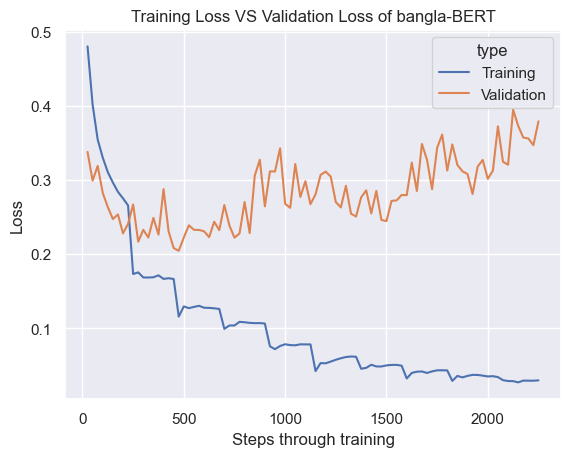

In [ ]:
lossData = {
    "steps": [],
    "loss": [],
    "type": []
}

for i,x in diba.iterrows():
    lossData["steps"].append(x["Steps"])
    lossData["steps"].append(x["Steps"])
    lossData["loss"].append(x[f"{model1}_Train_Loss"])
    lossData["loss"].append(x[f"{model1}_Validation_Loss"])
    lossData["type"].append("Training")
    lossData["type"].append("Validation")

lossTable = pd.DataFrame(lossData)
sns.set_theme()
sns.lineplot(data=lossTable, x="steps", y="loss", hue="type")
plt.xlabel("Steps through training")
plt.ylabel("Loss")
plt.title("Training Loss VS Validation Loss of bangla-BERT")
path = f'Loss_{model1}_graph.png'
os.makedirs(os.path.dirname('eval/'), exist_ok=True)
plt.savefig(f'eval/{path}', bbox_inches='tight')

## Select model

In [ ]:
model_name = 'csebuetnlp/banglabert'
#model_name = 'distilbert-base-multilingual-cased'
model1 = 'bangla-bert'
model2 = 'distil-bert'

# Load model

In [ ]:
##Loading from checkpoints
model = ABSA(model_name)
print(model_name)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss().to(device)
batch = 10
#PRETRAINED_MODEL = PRETRAINED_MODEL.replace("/", "-")
PATH = f'model/{model1}'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()
# # - or -
# # model.train()
# print(optimizer.state_dict())

# Predict on test data

In [ ]:
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd


# Define your dataset
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.reshape(len(labels), -1)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]#.clone().detach()
        return text, label




def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            sentiment = df.iloc[row, col]
            #if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            if sentiment == 1: one_hot = [1,0, 0] # Positive
            elif sentiment == 2: one_hot = [ 0, 1, 0] # Neutral
            elif sentiment == 3: one_hot = [0, 0, 1] # Negative
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return torch.tensor(outputs, dtype=torch.float32)


df_test = pd.read_csv('https://raw.githubusercontent.com/Sahim98/thesis-dataset/main/test.csv')
#y_val = make_outputs(df_val)
y_test = make_outputs(df_test)
#print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)

test_texts = df_test['Text'].values.tolist()
dataset1 = CustomDataset(test_texts,y_test)
#dataset2 = CustomDataset(val_texts,y_val)
test_loader = DataLoader(dataset1,batch_size=10,drop_last=True)
#val_loader = DataLoader(dataset2 ,batch_size=batch,drop_last=True)




Test outputs: torch.Size([40, 5, 3])


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tabulate import tabulate
from sklearn.metrics import f1_score

# Assuming the model, criterion, and test_loader are already defined
model.to("cuda")
replacements = {0: 'positive', 1: None, 2: 'negative'}  # Adjusted as per standard indexing
categories = df_test.columns[1:]


def predict(inputs):
    inputs = inputs.reshape(inputs.size(0), -1, 3)
    #print( torch.argmax(inputs, dim=-1))
    return torch.argmax(inputs, dim=-1)

def print_acsa_pred(text, sentence_pred, labels):
    sentiments = [replacements[x.item()] for x in sentence_pred]
    actual = [replacements[x.item()] for x in labels]
    print('---------------------------------------------------------------------')
    print(f'|{text}')
    # Prepare data for tabulate

    for category, actual_sent, pred_sent in zip(categories, actual, sentiments):
        if actual_sent != None or pred_sent != None:
          print('---------------------------------------------------------------------')
          print(f'| Category: {category} ')
          print(f'| Actual sentiement => {actual_sent}')
          print(f'| Predicted sentiment => {pred_sent}')
    print('---------------------------------------------------------------------')
    print('\n\n')


def test_model(loader):
    model.eval()
    losses = []
    f1_scores = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in loader:
            texts, labels = data
            outputs = model(texts).to(device)
            labels = labels.to(device)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            predicted_categories = predict(outputs)
            labels = predict(labels)
            f1s = []
            for i in range(batch):
                f1s.append(f1_score(predicted_categories[i].to("cpu"), labels[i].to("cpu"), average='weighted'))
            f1_scores.append(np.mean(f1s))


            correct_predictions += (predicted_categories == labels).sum().item()
            total_predictions += labels.numel()

            for i in range(len(texts)):
                print_acsa_pred(texts[i],  predicted_categories[i], labels[i])

    accuracy = correct_predictions / total_predictions

    print("Loss: ", np.mean(losses))
    print(f"Accuracy: {accuracy:.2%}")
    print(f"f1 scores: {np.mean(f1_scores):.2%}")

# Assuming df_test is defined and test_loader is your DataLoader for test data
test_model(test_loader)


---------------------------------------------------------------------
|মহান আল্লাহ পাক নিষ্ঠুর নন,তিনি যা করবেন,মুসলিম ও ঈমানদানগনের জন্যে রহমত
---------------------------------------------------------------------
| Category: God 
| Actual sentiement => positive
| Predicted sentiment => positive
---------------------------------------------------------------------
| Category: Religious#Group 
| Actual sentiement => None
| Predicted sentiment => positive
---------------------------------------------------------------------



---------------------------------------------------------------------
|আল্লাহ সর্বশক্তিমান আপনি আমাদের ইমন মজবুত করে দেন আমিন
---------------------------------------------------------------------
| Category: God 
| Actual sentiement => positive
| Predicted sentiment => positive
---------------------------------------------------------------------



---------------------------------------------------------------------
|আপনাকে মোবারক বাদ জানাই খুবই সুন্দর ভাবে গুছিয

# Predict random text

In [ ]:
def Prediction(inputs):
    y_pred = model(inputs)
    y_pred = y_pred.reshape(y_pred.size(0), -1, 3)
    return torch.argmax(y_pred, dim=-1)

def print_acsa(text, sentence_pred ):
    print('--------------------------------------------')
    print(f'| Input Sentence: {text}')
    sentiments = [replacements[x.item()] for x in sentence_pred]
    is_none = 1
    for category, pred_sent in zip(categories, sentiments):
        if pred_sent:
            is_none = 0
            print('--------------------------------------------')
            print('| Cateogry: ',category)
            print('| Predicted sentiment: ',pred_sent)
    if is_none:
        print('Do not lies in the defined religious aspect category')

    print('--------------------------------------------')

text = 'বাংলাদেশের হিন্দুরা অনেক খারাপ' # input('Enter your sentence: ')
text = 'বাংলাদেশের মুসলিমরা অনেক খারাপ'
text = 'মুসলিমরা জঙ্গিবাদে অবিশ্বাসী'
y_pred = Prediction(text)
print_acsa(text, y_pred[0])

--------------------------------------------
| Input Sentence: মুসলিমরা জঙ্গিবাদে অবিশ্বাসী
Do not lies in the defined religious aspect category
--------------------------------------------


# UI interface

In [ ]:
# import gradio as gr


# def print_acsa(text, sentence_pred ):
#     sentiments = [replacements[x.item()] for x in sentence_pred]

#     # Prepare data for tabulate
#     output = ''
#     for category, pred_sent in zip(categories, sentiments):
#         if pred_sent != None:
#             output+=f'{category} => {pred_sent}\n'
#     if output == '':
#         output = 'Do not line in the defined religious aspects category'
#     output = 'Predictions:\n' + output
#     return output


# def show(text):
#     y_pred = Prediction(text)
#     return print_acsa(text, y_pred[0])

# demo = gr.Interface(
#     fn=show,
#     inputs=gr.Textbox(lines=3, placeholder="Enter text"),
#     outputs=["text"],
#     title="ACSA prediction",
#     description="Enter a list of texts separated by commas and enclosed by [] to generate predictions"
# )

# demo.launch()


# Report matrics

### Aspect detection

In [ ]:

y_pred = Prediction(test_texts)
y_test_argmax = np.argmax(y_test, axis=-1).to("cpu").numpy()
y_pred = y_pred.to("cpu").numpy()
#y_test_argmax,y_pred


In [ ]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

                    precision    recall  f1-score   support

                       0.8571    0.8571    0.8571        14
               God     0.9412    1.0000    0.9697        16
   Religious#Group     1.0000    0.9286    0.9630        14
    Religious#Icon     1.0000    1.0000    1.0000        19
   Religious#Place     1.0000    1.0000    1.0000        20
Religious#Practice     0.9412    0.9412    0.9412        17

          accuracy                         0.9600       100
         macro avg     0.9566    0.9545    0.9552       100
      weighted avg     0.9606    0.9600    0.9600       100



### Polarity detection

In [ ]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = y_pred.flatten()

replacements = {1: None, 0: 'positive', 2: 'negative'}
target_names = list(map(str, replacements.values()))
target_names,y_test_flat.shape

(['None', 'positive', 'negative'], (100,))

In [ ]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))

              precision    recall  f1-score   support

        None     0.8571    0.8571    0.8571        14
    positive     0.9583    0.9079    0.9324        76
    negative     0.6429    0.9000    0.7500        10

    accuracy                         0.9000       100
   macro avg     0.8194    0.8883    0.8465       100
weighted avg     0.9126    0.9000    0.9036       100



# Aspect + Polarity

In [ ]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')

aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))

                             precision    recall  f1-score   support

                   God,None     0.9412    1.0000    0.9697        16
               God,positive     1.0000    0.7500    0.8571         4
       Religious#Group,None     0.7500    0.7500    0.7500         4
   Religious#Group,negative     1.0000    0.9000    0.9474        10
   Religious#Group,positive     0.8571    1.0000    0.9231         6
        Religious#Icon,None     1.0000    0.7895    0.8824        19
    Religious#Icon,negative     0.0000    1.0000    0.0000         0
    Religious#Icon,positive     1.0000    1.0000    1.0000         1
       Religious#Place,None     1.0000    1.0000    1.0000        20
    Religious#Practice,None     0.9375    0.8824    0.9091        17
Religious#Practice,negative     0.0000    1.0000    0.0000         0
Religious#Practice,positive     0.6667    0.6667    0.6667         3

                   accuracy                         0.9000       100
                  macro avg     

# Summary

In [ ]:
aspect_dict = aspect_report['macro avg']
aspect_dict['accuracy'] = aspect_report['accuracy']

polarity_dict  = polarity_report['macro avg']
polarity_dict['accuracy'] = polarity_report['accuracy']

aspect_polarity_dict = aspect_polarity_report['macro avg']
aspect_polarity_dict['accuracy'] = aspect_polarity_report['accuracy']

In [ ]:
df_report = pd.DataFrame.from_dict([aspect_dict, polarity_dict, aspect_polarity_dict])
df_report.index = ['Aspect Detection', 'Polarity Detection', 'Aspect + Polarity']
df_report.drop('support', axis=1)

,precision,recall,f1-score,accuracy
Aspect Detection,0.956583,0.954482,0.955163,0.96
Polarity Detection,0.819444,0.888346,0.846525,0.90
Aspect + Polarity,0.762707,0.894874,0.742116,0.90


In [ ]:
acsp_results = []
for index, pred in enumerate(y_pred):
    sentiments = map(lambda x: replacements[x], pred)
    result = {
        'id': f'#{index + 1}',
        'text': df_test['Text'][index],
        'acsa': []
    }
    for category, sentiment in zip(categories, sentiments):
        if sentiment: result['acsa'].append('{'+ category + ', ' + sentiment + '}')
    acsp_results.append(result)
acsp_results[:3]

[{'id': '#1',
  'text': 'মহান আল্লাহ পাক নিষ্ঠুর নন,তিনি যা করবেন,মুসলিম ও ঈমানদানগনের জন্যে রহমত',
  'acsa': ['{God, positive}', '{Religious#Group, positive}']},
 {'id': '#2',
  'text': 'আল্লাহ সর্বশক্তিমান আপনি আমাদের ইমন মজবুত করে দেন আমিন',
  'acsa': ['{God, positive}']},
 {'id': '#3',
  'text': 'আপনাকে মোবারক বাদ জানাই খুবই সুন্দর ভাবে গুছিয়ে শিক্ষণীয় হাদীস উপস্থাপন করার জন্য',
  'acsa': ['{Religious#Practice, positive}']}]

In [ ]:
with open('ACSA-religious.txt', 'w', encoding='utf-8') as f:
    for result in acsp_results:
        id, text, acsa = result.values()
        f.write(f"{id}\n{text}\n{', '.join(acsa)}\n\n")

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

3836